In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import os

# Load the datasets
weather_df = pd.read_csv("Resources/Canton_Ohio_Weather.csv")
cfs_df = pd.read_excel("Resources/cfs_data_Canton.xlsx")
reports_df = pd.read_excel("Resources/reported_crime.xlsx")

In [10]:
# Preprocess the data
# Clean and keep: Weather Data
# Columns to keep: dt_iso, temp, feels_like, temp_min, temp_max, humidity, weather_description, rain_1h, snow_1h
# Columns to make: temp_avg (To replace temp_min/temp_max for that hour?)
weather_df = weather_df[['dt_iso','temp','feels_like','temp_min','temp_max',
                         'humidity','weather_description','rain_1h','snow_1h']]

# Create the temp average for the hour
weather_df['temp_avg'] = (weather_df['temp_min'] + weather_df['temp_max'])/2

# Convert dt_iso to datetime and localize
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_convert("America/New_York")

# Create column to link on merge
weather_df['relation'] = weather_df['dt_iso'].dt.strftime("%Y-%m-%d %H:%M:%S")

weather_df.head()

,dt_iso,temp,feels_like,temp_min,temp_max,humidity,weather_description,rain_1h,snow_1h,temp_avg,relation
0,2014-12-31 19:00:00-05:00,21.63,9.03,21.60,22.44,42,sky is clear,NaN,NaN,22.02,2014-12-31 19:00:00
1,2014-12-31 20:00:00-05:00,21.51,8.91,20.98,22.44,46,sky is clear,NaN,NaN,21.71,2014-12-31 20:00:00
2,2014-12-31 21:00:00-05:00,21.51,9.19,20.98,22.44,46,sky is clear,NaN,NaN,21.71,2014-12-31 21:00:00
3,2014-12-31 22:00:00-05:00,20.57,7.97,20.52,22.44,48,sky is clear,NaN,NaN,21.48,2014-12-31 22:00:00
4,2014-12-31 23:00:00-05:00,20.57,8.02,20.52,21.36,48,sky is clear,NaN,NaN,20.94,2014-12-31 23:00:00


In [11]:
# Clean and keep: Calls for Service Data
# Columns to keep: CallType, CreateDatetime
# Create relation column for weather if needed
cfs_df = cfs_df[['CallType','CreateDatetime']]
cfs_df['relation'] = cfs_df['CreateDatetime'].dt.strftime("%Y-%m-%d %H:00:00")

cfs_df.head()

,CallType,CreateDatetime,relation
0,Disturbance,2023-12-22 21:09:34.750,2023-12-22 21:00:00
1,911 Hangup,2023-12-22 21:04:17.120,2023-12-22 21:00:00
2,911 Hangup,2023-12-22 20:44:22.477,2023-12-22 20:00:00
3,911 Hangup,2023-12-22 20:41:46.953,2023-12-22 20:00:00
4,Theft,2023-12-22 20:27:56.443,2023-12-22 20:00:00


In [12]:
# Clean and keep: Reported Crime
# Columns to keep: dordate, tor, offense, QOL_category, crimetype, crimeagainst, day_of_week
reports_df = reports_df[['dordate','tor', 'ti1', 'offense', 'QOL_category', 'crimetype', 'crimeagainst', 'day_of_week']]

# Rename columns
reports_df = reports_df.rename(columns={'dordate':'Report Date','tor':'Report Time','ti1':'Incident Time'})

# Keep only rows that have a full time of report time
reports_df = reports_df.loc[reports_df['Report Time'].str.len() >=8]

# Combine Date and time for relation column for weather if needed
reports_df['relation'] = reports_df['Report Date'] + pd.to_timedelta(reports_df['Report Time'])
reports_df['relation'] = reports_df['relation'].dt.strftime("%Y-%m-%d %H:00:00")


In [15]:
# Merge the DataFrames on the 'relation' column
combined_data = pd.merge(cfs_df, reports_df, on='relation', how='left')
combined_data = pd.merge(combined_data, weather_df, on='relation', how='left')



In [16]:
# Filter for "theft" in both datasets
theft_related_calls = combined_data[combined_data['CallType'].str.contains('THEFT', case=False, na=False)]
theft_related_crimes = combined_data[combined_data['offense'].str.contains('THEFT', case=False, na=False)]


In [31]:
# Filter the data to include only the years 2019 to 2023
theft_calls_2019_to_2023 = theft_related_calls[
    theft_related_calls['CreateDatetime'].dt.year.between(2019, 2023)
]
theft_crimes_2019_to_2023 = theft_related_crimes[
    theft_related_crimes['CreateDatetime'].dt.year.between(2019, 2023)
]

In [34]:
# Group the data by year and count the number of incidents
theft_calls_by_year = theft_calls_2019_to_2023['CreateDatetime'].dt.year.value_counts().sort_index()
theft_crimes_by_year = theft_crimes_2019_to_2023['CreateDatetime'].dt.year.value_counts().sort_index()


c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

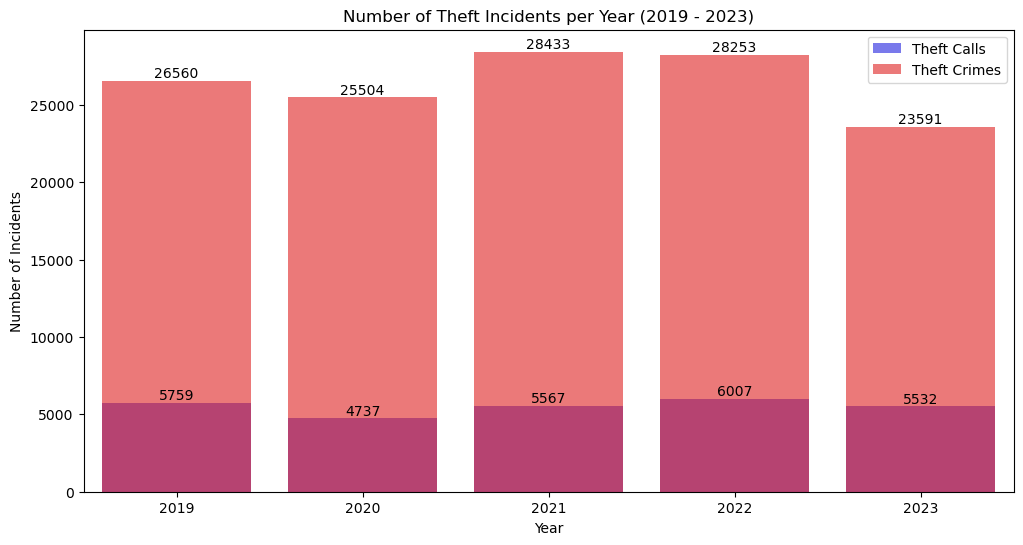

In [38]:
# Plot the data
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=theft_calls_by_year.index, y=theft_calls_by_year.values, label='Theft Calls', color='blue', alpha=0.6)
sns.barplot(x=theft_crimes_by_year.index, y=theft_crimes_by_year.values, label='Theft Crimes', color='red', alpha=0.6)

# Annotate each bar with the count
for i, value in enumerate(theft_calls_by_year.values):
    ax.text(i, value, f'{value}', ha='center', va='bottom', color='black')

for i, value in enumerate(theft_crimes_by_year.values):
    ax.text(i, value, f'{value}', ha='center', va='bottom', color='black')

plt.title('Number of Theft Incidents per Year (2019 - 2023)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend()
plt.xticks(range(len(theft_calls_by_year.index)), labels=theft_calls_by_year.index)
plt.show()

c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


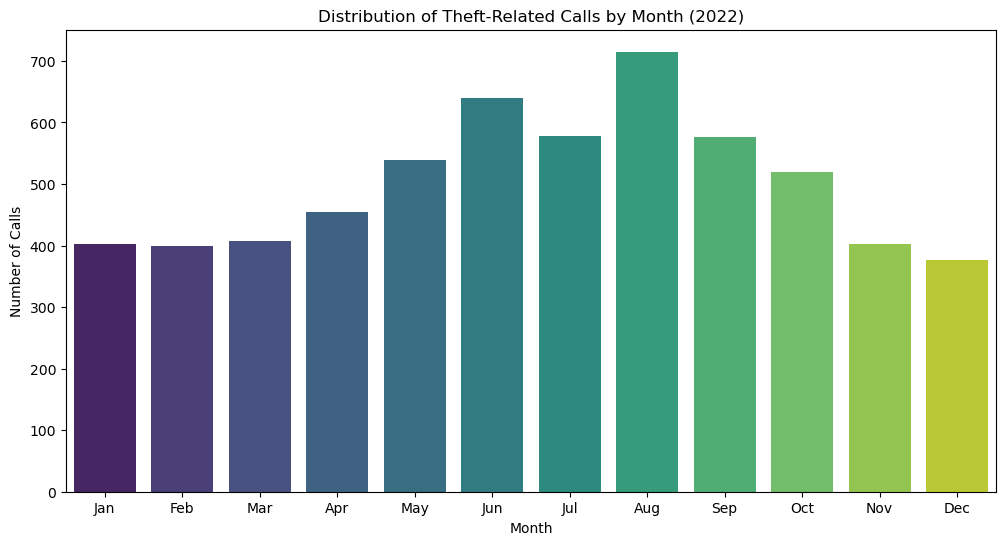

In [26]:
# Visualization 1: Distribution of Theft-Related Calls by Month for the year 2022
theft_calls_2022 = theft_related_calls[theft_related_calls['CreateDatetime'].dt.year == 2022]
plt.figure(figsize=(12, 6))
sns.countplot(x=theft_calls_2022['CreateDatetime'].dt.month, palette='viridis')
plt.title('Distribution of Theft-Related Calls by Month (2022)')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Stephen Haldi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


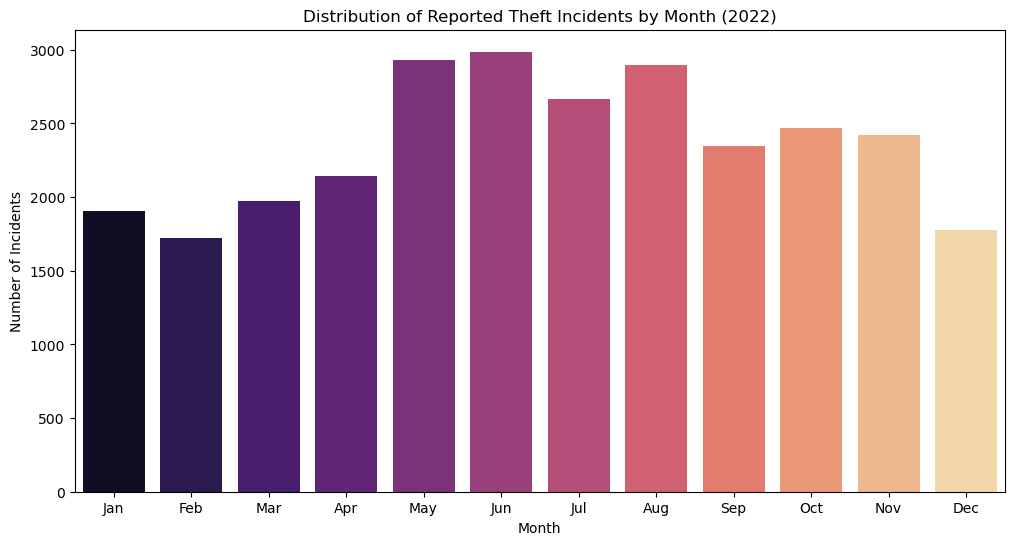

In [30]:
# Visualization 2: Distribution of Reported Theft Incidents by Month for the year 2022
theft_crimes_2022 = theft_related_crimes[
    theft_related_crimes['CreateDatetime'].dt.year == 2022
]
plt.figure(figsize=(12, 6))
sns.countplot(x=theft_crimes_2022['CreateDatetime'].dt.month, palette='magma')
plt.title('Distribution of Reported Theft Incidents by Month (2022)')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()